In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import pickle
import jax
import jax.numpy as jnp
import bayes3d as b
import genjax
import matplotlib.pyplot as plt

In [3]:
console = genjax.console(enforce_checkify=True)

In [4]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
with open('../data.pkl', 'rb') as f:
    data = pickle.load(f)

camera_image_1 = data["init"][0]
categories_on_table = data["init"][1]
target_category = data["init"][2]
table_info = data["init"][3] # table pose and dimensions
n_objects = 5

X_WT = b.t3d.pybullet_pose_to_transform(table_info[0])
X_WC = b.t3d.pybullet_pose_to_transform(camera_image_1["camera_pose"])
X_CT = b.t3d.inverse_pose(X_WC) @ X_WT

def image_to_rgbd(camera_image_1):
    K = camera_image_1['camera_matrix']
    rgb = camera_image_1['rgbPixels']
    depth = camera_image_1['depthPixels']
    camera_pose = camera_image_1['camera_pose']
    camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
    fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
    h,w = depth.shape
    rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
    return rgbd_original

rgbd_original = image_to_rgbd(camera_image_1)
print("Got rgbd_original")

scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)
print("Got rgb immage scaled down.")

b.setup_renderer(rgbd_scaled_down.intrinsics)

# os.path.join(os.path.abspath(''), 'bayes3d/assets/bop/ycbv/models')# 
model_dir = os.path.join(os.path.abspath('../..'), 'bayes3d/assets/bop/ycbv/models')
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
ycb_filenames = glob.glob(os.path.join(model_dir, "*.ply"))
ycb_index_order = [int(s.split("/")[-1].split("_")[-1].split(".")[0]) for s in ycb_filenames]
sorted_ycb_filenames = [s for _,s in sorted(zip(ycb_index_order, ycb_filenames))]

relevant_objects = [any(x in name for x in categories_on_table) for (i, name) in enumerate(b.utils.ycb_loader.MODEL_NAMES)]
relevant_object_names = [b.utils.ycb_loader.MODEL_NAMES[i] for i in range(len(b.utils.ycb_loader.MODEL_NAMES)) if relevant_objects[i]]
filtered_filenames = [sorted_ycb_filenames[i] for i in range(len(sorted_ycb_filenames)) if relevant_objects[i]]

table_dims = table_info[1:]
table_mesh = b.utils.make_cuboid_mesh(table_dims)
b.RENDERER.add_mesh(table_mesh, "table")
print("Added table mesh.")

pillar_mesh = b.utils.make_cuboid_mesh(jnp.array([0.02, 0.02, 0.5]))
b.RENDERER.add_mesh(pillar_mesh, "pillar")
print("Added pillar mesh.")

for model_path in filtered_filenames:
    b.RENDERER.add_mesh_from_file(model_path, scaling_factor=1.0/1000.0)
    print(f"Added mesh at path {model_path}.")

Got rgbd_original
Got rgb immage scaled down.


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)
Added table mesh.
Added pillar mesh.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000002.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000003.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000011.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000013.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000021.ply.


# Start using the model

In [138]:
from src.model2 import model, viz_trace_meshcat

In [139]:
importance_jit = jax.jit(model.importance)
key = jax.random.PRNGKey(0)

In [140]:
genjax.indexed_choice_map(
    [0, 1],
    genjax.choice_map({"a": jnp.array([3, 2])})
)

IndexedChoiceMap(
  indices=i32[2],
  inner=HierarchicalChoiceMap(trie=Trie(inner={'a': ChoiceValue(value=i32[2])}))
)

In [141]:
def flat_choicemaps_to_vector_choicemap(choicemaps):
    cm = genjax.choice_map({
        k : jnp.array([c.get_submap(k).get_value() for c in choicemaps])
        for (k, _) in choicemaps[0].get_submaps_shallow()
    })
    return cm

cm = flat_choicemaps_to_vector_choicemap([
    genjax.choice_map({"a": jnp.array([3, 2]), "b": jnp.array([1, 0])}),
    genjax.choice_map({"a": jnp.array([5, 4]), "b": jnp.array([3, 2])}),
])
console.print(cm)

(HierarchicalChoiceMap)
├── :a
│   └── (ValueChoice)
│       └──  i32[2,2]
└── :b
    └── (ValueChoice)
        └──  i32[2,2]

In [142]:
cm = genjax.choice_map({"a": jnp.array([3, 2])})
cm.get_submap("a")

ChoiceValue(value=i32[2])

In [173]:
map_choicemap = genjax.indexed_choice_map(
            jnp.array([0, 1, 2]),
            flat_choicemaps_to_vector_choicemap([
                genjax.choice_map({
                    "root_pose": X_CT,
                    "category_index": 0,
                    "parent_obj": -1,
                    "face_parent": 2,
                    "face_child": 3,
                    "contact_params": jnp.zeros(3)
                }),
                genjax.choice_map({
                    "root_pose": jnp.eye(4),
                    "parent_obj": 0,
                    "category_index": 2,
                    "face_parent": 2,
                    "face_child": 3,
                    "contact_params": jnp.zeros(3)
                }),
                genjax.choice_map({
                    "root_pose": jnp.eye(4),
                    "parent_obj": 1,
                    "category_index": 6,
                    "face_parent": 1,
                    "face_child": 4,
                    "contact_params": jnp.array([-0., 0., 0.2])
                })
            ])
        )

console.print(map_choicemap)

(IndexedChoiceMap,  i32[3])
└── (HierarchicalChoiceMap)
    ├── :root_pose
    │   └── (ValueChoice)
    │       └──  f32[3,4,4]
    ├── :category_index
    │   └── (ValueChoice)
    │       └──  i32[3]
    ├── :parent_obj
    │   └── (ValueChoice)
    │       └──  i32[3]
    ├── :face_parent
    │   └── (ValueChoice)
    │       └──  i32[3]
    ├── :face_child
    │   └── (ValueChoice)
    │       └──  i32[3]
    └── :contact_params
        └── (ValueChoice)
            └──  f32[3,3]

In [176]:
key = jax.random.PRNGKey(2)
trace, _ = importance_jit(key, genjax.choice_map({
        "camera_pose": jnp.eye(4),
        "objects": map_choicemap,
    }), (
        genjax.const(5), # max_n_objects
        1,               # n_objects
        # possible_object_indices
        jnp.arange(len(b.RENDERER.meshes)),
        # pose_bounds
        jnp.array([-jnp.ones(3)*5.0, jnp.ones(3)*5.0]),
        # contact_bounds
        jnp.array([jnp.array([-.5, -.5, -jnp.pi]), jnp.array([.5, .5, jnp.pi])]),
        # all_box_dims
        b.RENDERER.model_box_dims
    )
)

In [177]:
viz_trace_meshcat(trace)

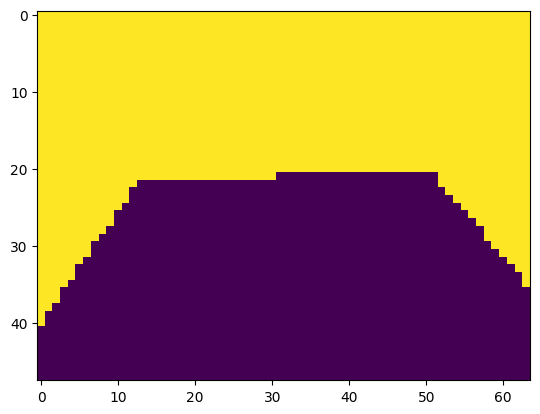

In [178]:
plt.imshow(trace["image"][:, :, 2])

In [149]:
trace["image"][:, :, 2]

Array([[1.0000000e+04, 1.0000000e+04, 1.0000000e+04, ..., 1.0000000e+04,
        1.0000000e+04, 1.0000000e+04],
       [1.0000000e+04, 1.0000000e+04, 1.0000000e+04, ..., 1.0000000e+04,
        1.0000000e+04, 1.0000000e+04],
       [1.0000000e+04, 1.0000000e+04, 1.0000000e+04, ..., 1.0000000e+04,
        1.0000000e+04, 1.0000000e+04],
       ...,
       [4.2948043e-01, 4.2948070e-01, 4.2948097e-01, ..., 4.2949617e-01,
        4.2949653e-01, 4.2949688e-01],
       [4.2086160e-01, 4.2086187e-01, 4.2086211e-01, ..., 4.2087656e-01,
        4.2087686e-01, 4.2087719e-01],
       [4.1258189e-01, 4.1258213e-01, 4.1258237e-01, ..., 4.1259626e-01,
        4.1259649e-01, 4.1259673e-01]], dtype=float32)

In [152]:
trace.get_retval().object_info.parent_obj

Array([   -1,     0,     1,     0, -1000], dtype=int32)

In [170]:
console.print(trace.get_retval().object_info)

ObjectInfo(
    parent_obj=Array([   -1,     0,     1,     0, -1000], dtype=int32),
    parent_face=Array([    2,     2,     1,     2, -1000], dtype=int32),
    child_face=Array([    3,     3,     4,     4, -1000], dtype=int32),
    category_index=Array([    0,     2,     6,     6, -1000], dtype=int32),
    root_pose=Array([[[-5.4998524e-02, -9.9848646e-01,  3.3535539e-08,  2.4800077e-02],
        [-7.2509176e-01,  3.9939445e-02, -6.8749315e-01,  1.8637428e-01],
        [ 6.8645257e-01, -3.7811164e-02, -7.2619092e-01,  6.0053611e-01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-3.3366072e-01, -4.4562629e-01, -8.3071524e-01,  3.0192614e+00],
        [ 2.7695176e-01,  7.9598916e-01, -5.3823698e-01, -2.2981024e+00],
        [ 9.0109283e-01, -4.0965655e-01, -1.4217329e-01, -3.6716914e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-1.2542284e-01,  3.6011600e-01, -9.2443800e-01,  3.6861057e+00],
        [ 9.0638340e-01,  4.2047894e-01,  4.0824801e-02,  3.6169138e+00],
        [ 4.0340838e-01, -8.3277488e-01, -3.7914079e-01, -4.4775844e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]],      dtype=float32),
    params=Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.1242144e-01,  1.2440455e-01,  2.1747053e+00],
       [-1.9570947e-01, -2.5739932e-01,  2.1437337e+00],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04]], dtype=float32)
)

In [95]:
trace.get_retval().poses

Array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]], dtype=float32)

# Walk through the model...

In [125]:
from src.model2 import generate_objects

In [126]:
(
    max_n_objects,
    n_objects,
    possible_object_indices,
    pose_bounds,
    contact_bounds,
    all_box_dims
) = (
    genjax.const(3), # max_n_objects
    2,               # n_objects
    # possible_object_indices
    jnp.arange(len(b.RENDERER.meshes)),
    # pose_bounds
    jnp.array([-jnp.ones(3)*5.0, jnp.ones(3)*5.0]),
    # contact_bounds
    jnp.array([jnp.array([-2, -2, -jnp.pi]), jnp.array([2.0, 2.0, jnp.pi])]),
    # all_box_dims
    b.RENDERER.model_box_dims
)

In [127]:
generate_objects_args = (
    jnp.arange(max_n_objects.const) < n_objects,
    (
        jnp.arange(max_n_objects.const),
        jnp.repeat(possible_object_indices[None, ...], max_n_objects.const, 0),
        jnp.repeat(pose_bounds[None, ...], max_n_objects.const, 0),
        jnp.repeat(contact_bounds[None, ...], max_n_objects.const, 0),
    )
)

In [128]:
tr, weight = generate_objects.importance(
    key,
    map_choicemap,
    generate_objects_args
)
masked_object_info = tr.get_retval()
console.print(weight)
console.print(masked_object_info)

-14.356093

(Mask,  bool[3])
└── ObjectInfo
    ├── parent_obj
    │   └──  i32[3]
    ├── parent_face
    │   └──  i32[3]
    ├── child_face
    │   └──  i32[3]
    ├── category_index
    │   └──  i32[3]
    ├── root_pose
    │   └──  f32[3,4,4]
    └── params
        └──  f32[3,3]

In [129]:
from src.masking_utils import mymatch
from src.model2 import empty_object_info, is_valid
object_info = mymatch(
    masked_object_info,
    lambda: empty_object_info(),
    lambda x: x
)
camera_pose = jnp.eye(4)

In [130]:
valid_box_dims = jnp.where(
        is_valid(object_info)[:, None],
        all_box_dims[object_info.category_index],
        jnp.zeros(3)
    )
console.print(valid_box_dims)

[[0.75       1.22       0.03      ]
 [0.07173    0.16397701 0.21348599]
 [0.         0.         0.        ]]

In [137]:
poses = jnp.where(
    is_valid(object_info)[:, None, None],
    b.scene_graph.poses_from_scene_graph(
        object_info.root_pose,
        valid_box_dims,
        object_info.parent_obj, object_info.params,
        object_info.parent_face, object_info.child_face
    ),
    jnp.zeros((3, 4, 4))
)
console.print(poses)

[[[-5.4998524e-02 -9.9848646e-01  3.3535539e-08  2.4800077e-02]
  [-7.2509176e-01  3.9939445e-02 -6.8749315e-01  1.8637428e-01]
  [ 6.8645257e-01 -3.7811164e-02 -7.2619092e-01  6.0053611e-01]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[-9.9848640e-01  5.4998461e-02  9.6667478e-08  2.4800088e-02]
  [ 3.9939445e-02  7.2509170e-01 -6.8749315e-01  1.0267680e-01]
  [-3.7811246e-02 -6.8645251e-01 -7.2619092e-01  5.1212746e-01]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]]]

In [124]:
console.print((
    object_info.root_pose,
    valid_box_dims,
    object_info.parent_obj, object_info.params,
    object_info.parent_face, object_info.child_face
))

(
    Array([[[-5.4998524e-02, -9.9848646e-01,  3.3535539e-08,  2.4800077e-02],
        [-7.2509176e-01,  3.9939445e-02, -6.8749315e-01,  1.8637428e-01],
        [ 6.8645257e-01, -3.7811164e-02, -7.2619092e-01,  6.0053611e-01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[           nan,            nan,            nan,            nan],
        [           nan,            nan,            nan,            nan],
        [           nan,            nan,            nan,            nan],
        [           nan,            nan,            nan,            nan]]],      dtype=float32),
    Array([[0.75      , 1.22      , 0.03      ],
       [0.07173   , 0.16397701, 0.21348599],
       [0.        , 0.        , 0.        ]], dtype=float32),
    Array([   -1,     0, -1000], dtype=int32),
    Array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [nan, nan, nan]], dtype=float32),
    Array([    2,     2, -1000], dtype=int32),
    Array([    3,     3, -1000], dtype=int32)
)

## even lower level debugging...

In [20]:
from src.model2 import generate_object

In [21]:
mask_cm = tr.get_choices().get_submap(0).unmask()
console.print(mask_cm)

(HierarchicalChoiceMap)
├── :root_pose
│   └── (ValueChoice)
│       └──  f32[4,4]
├── :contact_params
│   └── (ValueChoice)
│       └──  f32[3]
├── :parent_obj
│   └── (ValueChoice)
│       └──  i32[]
├── :face_parent
│   └── (ValueChoice)
│       └──  i32[]
├── :category_index
│   └── (ValueChoice)
│       └──  i32[]
└── :face_child
    └── (ValueChoice)
        └──  i32[]

In [22]:
mask_args = (
    True, (0, possible_object_indices, pose_bounds, contact_bounds)
)

In [23]:
masked = genjax.masking_combinator(generate_object)

In [24]:
isinstance(mask_cm, genjax.Choice)

True

In [25]:
type(mask_cm)

genjax._src.core.datatypes.generative.HierarchicalChoiceMap

In [26]:
tr_, weight = masked.importance(key, mask_cm, mask_args)

<class 'jaxlib.xla_extension.ArrayImpl'>


In [ ]:
type(weight)

jaxlib.xla_extension.ArrayImpl

In [ ]:
from genjax._src.generative_functions.combinators.masking_combinator import MaskingTrace

In [ ]:
(check, inner_args) = mask_args
tr_, w_ = masked.inner.importance(key, mask_cm, inner_args)
w_ = check * w_
MaskingTrace(masked, tr_, check)

MaskingTrace(
  mask_combinator=MaskingCombinator(
    inner=StaticGenerativeFunction(source=<function generate_object>)
  ),
  inner=StaticTrace(
    gen_fn=StaticGenerativeFunction(source=<function generate_object>),
    args=(0, i32[7], f32[2,3], f32[2,3]),
    retval=ObjectInfo(
      parent_obj=i32[],
      parent_face=i32[],
      child_face=i32[],
      category_index=i32[],
      pose=f32[4,4],
      params=f32[3]
    ),
    address_choices=Trie(
      inner={
        'parent_obj':
        DistributionTrace(
          gen_fn=UniformDiscrete(),
          args=(-1, 0),
          value=i32[],
          score=f32[]
        ),
        'face_parent':
        DistributionTrace(
          gen_fn=UniformDiscrete(),
          args=(0, 6),
          value=i32[],
          score=f32[]
        ),
        'face_child':
        DistributionTrace(
          gen_fn=UniformDiscrete(),
          args=(0, 6),
          value=i32[],
          score=f32[]
        ),
        'category_index':
       

In [29]:
isinstance(map_choicemap, genjax.Choice)

True

In [30]:
generate_objects.importance(
    key,
    map_choicemap,
    generate_objects_args
)

<class 'jax._src.interpreters.batching.BatchTracer'>


(MapTrace(
   gen_fn=MapCombinator(
     kernel=MaskingCombinator(
       inner=StaticGenerativeFunction(source=<function generate_object>)
     ),
     in_axes=(0, (0, 0, 0, 0))
   ),
   inner=MaskingTrace(
     mask_combinator=MaskingCombinator(
       inner=StaticGenerativeFunction(source=<function generate_object>)
     ),
     inner=StaticTrace(
       gen_fn=StaticGenerativeFunction(source=<function generate_object>),
       args=(i32[2], i32[2,7], f32[2,2,3], f32[2,2,3]),
       retval=ObjectInfo(
         parent_obj=i32[2],
         parent_face=i32[2],
         child_face=i32[2],
         category_index=i32[2],
         pose=f32[2,4,4],
         params=f32[2,3]
       ),
       address_choices=Trie(
         inner={
           'root_pose':
           DistributionTrace(
             gen_fn=UniformPose(),
             args=(f32[2,3], f32[2,3]),
             value=f32[2,4,4],
             score=f32[2]
           ),
           'contact_params':
           DistributionTrace(
       

In [ ]:
from src.model2 import empty_object_info
from src.masking_utils import mymatch
object_info = mymatch(
    masked_object_info,
    lambda: empty_object_info(),
    lambda x: x
)
console.print(object_info)


ObjectInfo(
    parent_obj=Array([-1, -1], dtype=int32),
    parent_face=Array([0, 0], dtype=int32),
    child_face=Array([2, 4], dtype=int32),
    category_index=Array([6, 5], dtype=int32),
    pose=Array([[[ 0.21296251,  0.8599319 ,  0.4638577 , -3.6455798 ],
        [ 0.11613947,  0.44910288, -0.88589954, -2.5233161 ],
        [-0.97013324,  0.24253568, -0.00422996, -3.2954419 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.5552132 ,  0.14355308, -0.8192253 , -3.0910385 ],
        [ 0.40515423,  0.8135369 ,  0.4171414 , -3.0263913 ],
        [ 0.72635233, -0.56351525,  0.39352548,  1.8770814 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]],      dtype=float32),
    params=Array([[-0.36309052, -0.07025099,  1.5729983 ],
       [-0.8348894 ,  0.2492876 ,  1.419142  ]], dtype=float32)
)

In [ ]:
camera_pose = jnp.eye(4)

In [ ]:
valid_box_dims = jnp.where(
    (object_info.category_index == -1)[:, None],
    jnp.zeros(3),
    all_box_dims[object_info.category_index]
)

In [ ]:
poses = b.scene_graph.poses_from_scene_graph(
        object_info.pose,
        valid_box_dims,
        object_info.parent_obj, object_info.params,
        object_info.parent_face, object_info.child_face
    )

In [ ]:
jnp.linalg.inv(camera_pose) @ poses

Array([[[ 0.21296251,  0.8599319 ,  0.4638577 , -3.6455798 ],
        [ 0.11613947,  0.44910288, -0.88589954, -2.5233161 ],
        [-0.97013324,  0.24253568, -0.00422996, -3.2954419 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.5552132 ,  0.14355308, -0.8192253 , -3.0910385 ],
        [ 0.40515423,  0.8135369 ,  0.4171414 , -3.0263913 ],
        [ 0.72635233, -0.56351525,  0.39352548,  1.8770814 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]],      dtype=float32)

In [ ]:
object_info

ObjectInfo(parent_obj=Array([-1, -1], dtype=int32), parent_face=Array([0, 0], dtype=int32), child_face=Array([2, 4], dtype=int32), category_index=Array([6, 5], dtype=int32), pose=Array([[[ 0.21296251,  0.8599319 ,  0.4638577 , -3.6455798 ],
        [ 0.11613947,  0.44910288, -0.88589954, -2.5233161 ],
        [-0.97013324,  0.24253568, -0.00422996, -3.2954419 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.5552132 ,  0.14355308, -0.8192253 , -3.0910385 ],
        [ 0.40515423,  0.8135369 ,  0.4171414 , -3.0263913 ],
        [ 0.72635233, -0.56351525,  0.39352548,  1.8770814 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]],      dtype=float32), params=Array([[-0.36309052, -0.07025099,  1.5729983 ],
       [-0.8348894 ,  0.2492876 ,  1.419142  ]], dtype=float32))

In [ ]:
rendered = b.RENDERER.render(jnp.linalg.inv(camera_pose) @ poses, object_info.category_index)[..., :3]
